In [212]:
#%pip install numpy scipy tabulate

O objetivo dessa tarefa foi bem simples: implementar diferentes decomposições matriciais
e estimar o erro residual e estabilidade dos algoritmos a partir do cálculo
da pseudoinversa das matrizes decompostas, por meio das resultantes da decomposição.

In [213]:
import numpy as np
from tabulate import tabulate
from scipy import linalg

#### Definições

In [214]:
n_to_test = [4, 6, 8, 10]
eps = 2.2 * 1e-16

$e_\text{algoritmo} = \frac{||\tilde{X}_\text{algoritmo} - A^\dagger||_2}{\epsilon_M ||A^\dagger||_2 \mathcal{k}_2(A)}$

In [215]:
# fator de estabilidade
def e_alg(X_alg, A_pinv):
    # a norma padrão do numpy é 2
    norm_diff = np.linalg.norm(X_alg - A_pinv)
    norm_A_pinv = np.linalg.norm(A_pinv)
    # igualmente, a condição padrão é 2
    cond_A = np.linalg.cond(A_pinv)
    return norm_diff / (eps * norm_A_pinv * cond_A)

$res_\text{algoritmo} = \frac{||\tilde{X}_\text{algoritmo}A - I_n||_2}{||A||_2 ||\tilde{X}_\text{algoritmo}||_2}$

In [216]:
# erro residual
def res_alg(X_alg, A):
    id = np.eye(A.shape[0]) # assumindo que A é quadrada
    norm_diff = np.linalg.norm(X_alg @ A - id)
    norm_A = np.linalg.norm(A)
    norm_X_alg = np.linalg.norm(X_alg)
    return norm_diff / (norm_A * norm_X_alg)

#### Pseudo-inversa de Moore-Penrose

$$A^\dagger = (A^TA)^{-1}A^T

#### Decomposição Cholesky

$$A = LL^T,$$

onde $A$ é definida positiva, $L$ é uma matriz triangular inferior com entradas diagonais estritamente positivas.

In [217]:
# Cholesky
def chol(A):
    # calculamos a inversa de A.TA
    M = A.T @ A
    # resolvemos a inversa de A.T @ A via Cholesky
    R = np.linalg.cholesky(M, upper=True)
    Y = np.linalg.solve(R.T, A.T)
    X = np.linalg.solve(R, Y)
    return X

#### Processo de ortonormalização de Gram-Schmidt

Usaremos na decomposição QR

1. Ortogonalização: $\tilde{q}_i = a_i - (q_1^T a_i)q_1 - \cdots - (q_{i - 1}^T a_i)q_{i-1}$
1. Se $||\tilde{q}_i|| = 0$, paramos ($\tilde{q}_i$ é L.D. dos anteiores e, portanto, redundante).
1. Normalização: $q_i = \frac{\tilde{q}_i}{||\tilde{q}_i||}$, para garantir $||q_i||_2 = 1$.

Perceba que o processo falharia no últomo passo com $||\tilde{q}_i|| = 0$.

In [218]:
# Método de Gram-Schmidt, para uso na decomposição QR
def gs(a):
    # coleção de vetores q, a ser construída
    q = []
    for i in range(len(a)):
        # montando q~ (aqui chamado de qt, "q til")
        qt = a[i]
        for j in range(i):
            # ortogonalização
            qt = qt - (np.dot(q[j], a[i]) * q[j])
        norm_qt = np.linalg.norm(qt)
        # se q~ = 0, sair
        if norm_qt == 0:
            return q
        # senão, normalize
        q.append(qt / norm_qt)
    return q

#### Decomposição QR

$$A = QR$$

Onde as colunas de $Q$ são vetores ortonormais e $R$ é uma matriz triangular superior.

Nossa implementação constrói $Q$ a partir da aplicação do método de Gram-Schmidt em $A$
(no caso, como desejamos apenas a pseudoinversa, aplicamos em $A^T$).

In [219]:
# Decomposição QR
def qr(A):
    Qt = gs(A.T)
    # Como sabe-se que A = QR ...
    R_inv = np.linalg.pinv(Qt @ A)
    return R_inv @ Qt

Uma pequena modificação no método de Gram-Schmidt pode nos trazer mais estabilidade numérica

$\tilde{q}_i = a_i - (q_1^T \tilde{q}_i )q_1 - \cdots - (q_{i - 1}^T \tilde{q}_i )q_{i-1}$

In [220]:
# Método de Gram-Schmidt modificado
def mgs(a):
    q = []
    for i in range(len(a)):
        qt = a[i]
        for j in range(i):
            # perceba a única, sutil, porém crucial diferença
            qt = qt - (np.dot(q[j], qt) * q[j])
        norm_qt = np.linalg.norm(qt)
        if norm_qt == 0:
            return q
        q.append(qt / norm_qt)
    return q

In [221]:
# QR com método de Gram-Schmidt modificado
def qr_mgs(A):
    Qt = mgs(A.T)
    R_inv = np.linalg.pinv(Qt @ A)
    return R_inv @ Qt

**Decomposição SVD**, exaustivamente estudada na disciplina.

In [222]:
# SVD
def svd(A):
    U, S, Vt = np.linalg.svd(A)
    S_inv = np.diag(1 / S)
    return Vt.T @ S_inv @ U.T

#### Bateria de testes final

In [223]:
n_results = {}
for n in n_to_test:
    print('Processando n =', n)
    A = linalg.pascal(n)
    A_inv = np.linalg.pinv(A) # não é necessário pseudoinversa
    cond_A = np.linalg.cond(A)
    # calculando as pseudo-inversas
    X_chol = chol(A)
    X_qr = qr(A)
    X_qrp = qr_mgs(A)
    X_svd = svd(A)
    # calculando a estabilidade
    e_chol = e_alg(X_chol, A_inv)
    e_qr = e_alg(X_qr, A_inv)
    e_qrp = e_alg(X_qrp, A_inv)
    e_svd = e_alg(X_svd, A_inv)
    # calculando o erro residual
    res_chol = res_alg(X_chol, A)
    res_qr = res_alg(X_qr, A)
    res_qrm = res_alg(X_qrp, A)
    res_svd = res_alg(X_svd, A)
    # salvando os resultados
    n_results[str(n)] = {
        "cond": cond_A,
        "chol": {
            "e": e_chol,
            "res": res_chol
        },
        "qr": {
            "e": e_qr,
            "res": res_qr
        },
        "qrp": {
            "e": e_qrp,
            "res": res_qrm
        },
        "svd": {
            "e": e_svd,
            "res": res_svd
        }
    }

Processando n = 4
Processando n = 6
Processando n = 8
Processando n = 10


In [224]:
table_e = []
table_res = []
for n in n_results:
    table_e.append([n, n_results[n]["cond"],
                  n_results[n]["chol"]["e"],
                  n_results[n]["qr"]["e"],
                  n_results[n]["qrp"]["e"],
                  n_results[n]["svd"]["e"]])
    
    table_res.append([n, n_results[n]["cond"],
                    n_results[n]["chol"]["res"],
                    n_results[n]["qr"]["res"],
                    n_results[n]["qrp"]["res"],
                    n_results[n]["svd"]["res"]])

In [225]:
tabulate(table_e, headers=["n", "cond(A)", "e_chol", "e_qr", "e_qrp", "e_svd"], tablefmt="html")

n,cond(A),e_chol,e_qr,e_qrp,e_svd
4,691.937,5.83632,0.116024,0.116024,0.000518293
6,110787,412.454,0.0529473,0.0362844,2.22249e-06
8,2.06452e+07,40849.2,0.0042788,0.0038168,2.15637e-08
10,4.15521e+09,210862,0.0177015,0.00178709,1.18201e-10


In [226]:
tabulate(table_res, headers=["n", "cond(A)", "res_chol", "res_qr", "res_qrm", "res_svd"], tablefmt="html")

n,cond(A),res_chol,res_qr,res_qrm,res_svd
4,691.937,1.33544e-14,3.56021e-17,3.56021e-17,7.24e-17
6,110787,1.28769e-12,9.14868e-18,8.83636e-18,2.70652e-17
8,2.06452e+07,1.50054e-10,5.53114e-18,3.94864e-18,4.23236e-17
10,4.15521e+09,2.87839e-08,2.73691e-16,3.19657e-18,1.40453e-17


Como podemos ver, o QR com Gram-Schmidt modificado é, de fato, mais estável (a ordem do erro se mantém, enquanto no "normal" aumenta duas ordens).

### Outras decomposições

Nessas, testei apenas a reconstrução.

#### ST

Theorem 2.1. For every nonsingular and nonsymmetric n×n matrix A, whose
leading principal submatrices are nonsingular, there exists a decomposition A = ST
where S is symmetric and T is unit triangular.

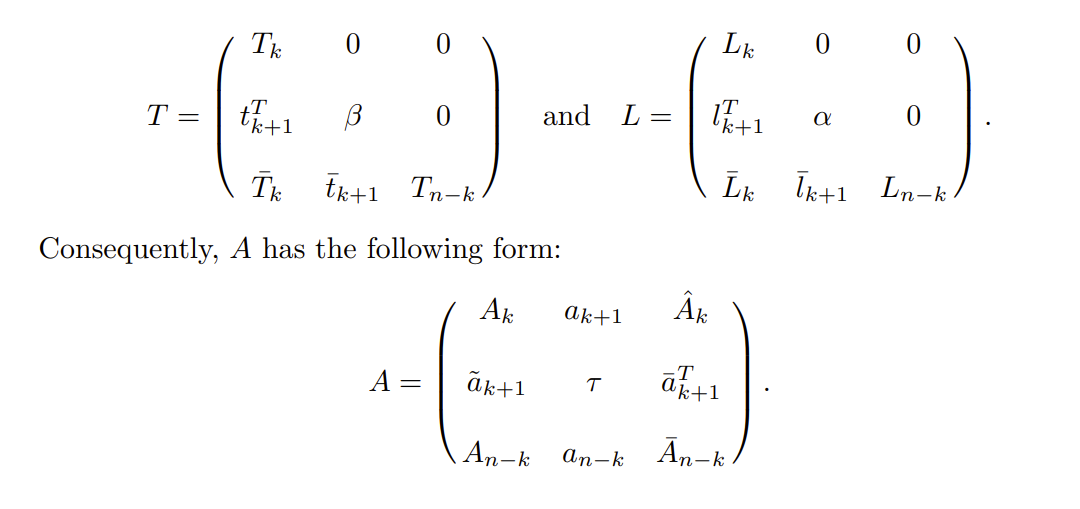

O código abaixo segue os passos apresentados por esses trechos (também do artigo original)

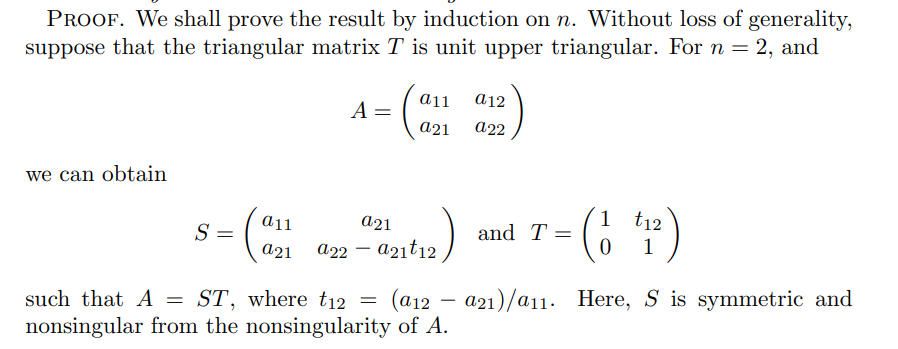
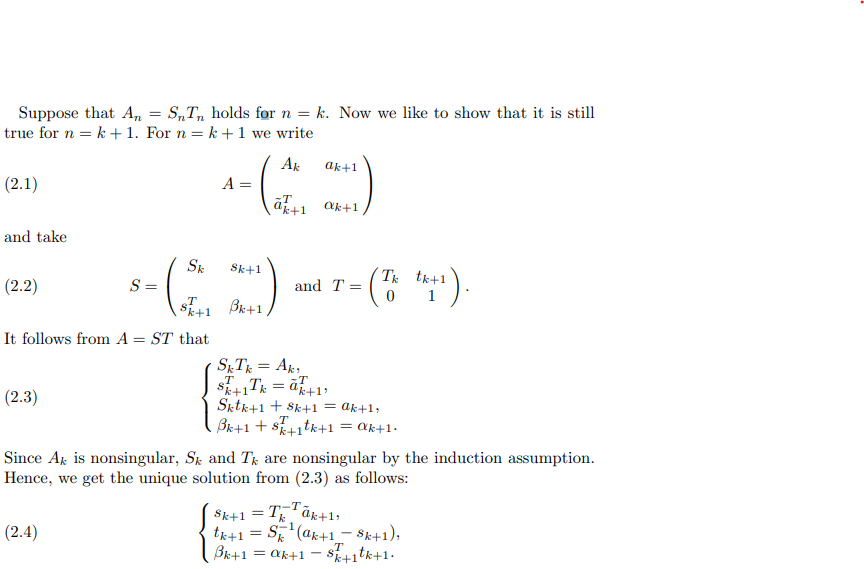

In [227]:
def ST(A):
    # For every nonsingular and nonsymmetric n×n matrix A...
    if np.linalg.det(A) == 0:
        raise ValueError("Matrix is singular")
    
    if np.allclose(A, A.T):
        raise ValueError("Matrix is symmetric")

    n = A.shape[0]

    if (n != A.shape[1]):
        raise ValueError("Matrix is not square")

    S = np.zeros((n, n))
    T = np.zeros((n, n))

    T[0, 0] = 1
    T[0, 1] = (A[0][1] - A[1][0])/A[0][0]
    T[1, 1] = 1
    T[1, 0] = 0

    S[0, 0] = A[0][0]
    S[0, 1] = A[1][0]
    S[1, 0] = A[1][0]
    S[1, 1] = A[1][1] - A[1][0]*T[0][1]

    for k in range(2, n):
        T[k] = 0
        T[k][k] = 1

        s = np.linalg.inv(T[:k,:k].T) @ A[k][:k]
        S[k][:k] = s
        S[:k, k] = s

        t = np.linalg.inv(S[:k,:k]) @ (A[:k, k] - S[:k, k])
        T[:k, k] = t

        S[k][k] = A[k][k] - (s @ t)
    return S, T

#### TS

$L$

$S = LL^T$

In [228]:
# valeu Diego (?)
def TS(A, n):
    T = np.zeros((n, n))
    S = np.zeros((n, n))
    L = np.zeros((n, n))
    Lt = np.zeros((n, n))

    detA = np.linalg.det(A[:2,:2])
    T[0, 0] = A[0, 0]
    T[0, 1] = 0
    T[1, 0] = A[1, 0] - (A[0, 1] * detA)/A[0, 0]
    T[1, 1] = detA

    S[0, 0] = 1
    S[0, 1] = A[0, 1]/A[0, 0]
    S[1, 0] = A[0, 1]/A[0, 0]
    S[1, 1] = (1/A[0, 0]) + (A[0, 1]/A[0, 0])**2

    L[:2,:2] = np.linalg.cholesky(S[:2,:2])

    Lt[:2,:2] = L[:2,:2].T
    
    for k in range(2, n):
        t_inv = np.linalg.inv(T[:k,:k])
        l_inv = np.linalg.inv(L[:k,:k])
        lt_inv = np.linalg.inv(Lt[:k,:k])

        l = l_inv @ t_inv @ A[:k, k]
        L[:k,k] = 0
        L[k, :k] = l
        Lt[:k,k] = l
        Lt[k, :k] = 0

        beta = 1
        if ((A[k, k] - (A[k, :k] @ lt_inv @ l_inv @ t_inv @ A[:k, k])) / beta) < 0:
            beta = -beta
        tau = np.sqrt((A[k, k] - (A[k, :k] @ lt_inv @ l_inv @ t_inv @ A[:k, k])) / beta)

        t = (A[k, :k] @ lt_inv @ l_inv) - (beta * l @ l_inv)
        T[:k, k] = 0
        T[k, :k] = t

        T[k, k] = beta
        L[k, k] = tau
        Lt[k, k] = tau
    S = L @ Lt
    return T, S

#### Conjugada

In [229]:
def conjugada(A, n):
    P = np.identity(n)
    for i in range(n):
        for j in range(i):
            P[:, i] = (np.dot(P[:, j], P[:, j].T @ A @ P[:, i]) / (P[:, j].T @ A @ P[:, j])) - P[:, i]
    D = P.T @ A @ P
    return P, D

### Testando essas decomposições

In [230]:
n_to_test_2 = [3, 4, 50, 100, 200]

In [231]:
# não entendi se era pra testar a inversa ou a decomposição em si
# pelo tamanho, imagino que seja apenas a recuperação da matriz original
table_rows = []
np.random.seed(6661)
for n in n_to_test_2:
    A = np.random.rand(n, n)
    s1, t1 = ST(A)
    t1, s1 = TS(A, n)
    p, d = conjugada(A, n)
    X_st = s1 @ t1
    X_ts = t1 @ s1
    X_conj = p @ d @ p.T

    err_st = np.linalg.norm(A - X_st)
    err_ts = np.linalg.norm(A - X_ts)
    err_conj = np.linalg.norm(A - X_conj)

    row = [n, err_st, err_ts, err_conj]
    table_rows.append(row)

In [232]:
tabulate(table_rows, headers=["n", "err_st", "err_ts", "err_conj"], tablefmt="html")

n,err_st,err_ts,err_conj
3,9.67929,3.35659e-16,4.83338
4,16.7691,2.36855e-15,2.83674
50,2.34828e+08,4.41447e-07,4.35493e+10
100,2.55105e+09,1.76195e-05,3.67531e+09
200,1.3381e+09,5.08522e-05,1.57043e+10
